# 演習（最適化アルゴリズムの数値検証）

## 下準備

まず、実験の準備として、以下の3つのコードブロックを実行していこう（まずは中身を読み飛ばして良い）。

In [1]:
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

fontsize = "xx-large"
cmap = cm.jet

In [2]:
class Iterative:
    '''
    Simple algorithm base class, for iterative procedures.
    '''

    ## Clerical methods. ##

    def __init__(self, w_init, t_max=None, thres=None,
                 store=False, name=""):

        # Check the user-passed attributes.
        
        self.w = np.copy(w_init)
        self.t_max = t_max
        self.thres = thres
        self.store = store
        self.name = name

        if self.t_max is None and self.thres is None:
            raise ValueError("Must provide at least one stopping condition.")
        
        # Attributes determined internally.
        self.early_stop = False
        self.diff = np.inf # to record difference with previous step.
        if self.thres is None:
            self.w_old = None
            self.thres = -1.0
        else:
            self.w_old = np.copy(self.w)

        self.t = None # to count the number of steps.
        if self.t_max is None:
            self.t_max = np.inf
        if self.store and self.t_max is not None: # for storing states.
            self.wstore = np.zeros((self.w.size,t_max+1), dtype=self.w.dtype)
            self.wstore[:,0] = self.w.flatten()
        else:
            self.wstore = None
    

    def __iter__(self):
        self.t = 0
        return self

    
    def __next__(self):
        '''
        Check the stopping condition(s).
        '''
        
        if self.t >= self.t_max:
            raise StopIteration
        
        if self.diff < self.thres:
            raise StopIteration

        if self.early_stop:
            raise StopIteration
        

    def update(self, model=None, data=None):
        raise NotImplementedError("To be implemented by sub-classes.")

    
    def _monitor(self, model=None, data=None):
        
        self.t += 1 # Always record step increase.
        
        if self.thres > 0.0: # Record differences when desired.
            self.diff = np.linalg.norm((self.w-self.w_old))
            self.w_old = np.copy(self.w)
            
        if self.wstore is not None:
            self.wstore[:,self.t] = self.w.flatten()
        

class LineSearch(Iterative):
    '''
    Basic archetype of an iterator for implementing
    line search optimization routines.
    '''

    ## Clerical methods. ##

    def __init__(self, w_init, step, t_max=None, thres=None, store=False, name="LineSearch"):

        super(LineSearch, self).__init__(w_init=w_init, t_max=t_max,
                                         thres=thres,
                                         store=store, name=name)

        self.step = step


    def update(self, model=None, data=None):

        if model is None:
            raise ValueError("At least need model to update.")

        # Parameter update.
        newdir = self.newdir(model=model, data=data)
        stepsize = self.step(t=self.t, model=model, data=data, newdir=newdir)
        self.w += stepsize * newdir.T

        # Update various elements being monitored.
        self._monitor(model=model, data=data)
        

    def newdir(self, model, data):
        '''
        This will be implemented by sub-classes
        that inherit this class.
        '''
        raise NotImplementedError


class GD_Optim(LineSearch):
    '''
    Optimization of a known function via gradient descent.
    '''
    
    ## Clerical methods. ##

    def __init__(self, w_init, step, t_max=None, thres=None, store=False, name="GD_Optim"):

        super().__init__(w_init=w_init, step=step,
                                       t_max=t_max, thres=thres,
                                       store=store, name=name)
    
    ## Implementation of new direction computation. ##
    
    def newdir(self, model, data=None):

        return (-1) * model.g_opt(w=self.w)

In [3]:
class Function:
    '''
    Base class for models which are just fixed functions.
    '''

    ## Clerical methods. ##
    def __init__(self, name=""):
        self.name = name

    def __str__(self):
        out = "Model name: {}".format(self.name)
        return out
    
    def __call__(self, w):
        return self.f_opt(w=w)

    ## Computation-related methods. ##
    def f_opt(self, w=None):
        '''
        Returns the function value; implement in sub-classes.
        '''
        raise NotImplementedError
    
    def g_opt(self, w=None):
        '''
        Returns the gradient; implement in sub-classes.
        '''
        raise NotImplementedError


class Quadratic1D(Function):
    '''
    1-dim quadratic function.
    '''
    
    ## Clerical methods. ##

    def __init__(self, shift=0.0, scale=0.5, name="Quadratic1D"):
        
        super().__init__(name=name)
        
        # Function is fully determined by user-passed parameters.
        self.shift = shift
        self.scale = scale
    
    
    def f_opt(self, w):
        
        # Keep shape of w here for vectorizing.
        return (w-self.shift)**2 * self.scale
    
    
    def g_opt(self, w):
        
        # Keep shape of w here.
        return 2*(w-self.shift)*self.scale
    
    
class Poly15(Function):
    '''
    Polynomial between absolute value and quadratic.
    '''
    
    ## Clerical methods. ##

    def __init__(self, shift=0.0, scale=2./3., name="Poly15"):
        
        super().__init__(name=name)
        
        # Function is fully determined by user-passed parameters.
        self.shift = shift
        self.scale = scale
    
    def f_opt(self, w):
        # Keep shape of w here for vectorizing.
        return np.abs(w-self.shift)**(1.5) * self.scale
    
    def g_opt(self, w):
        # Keep shape of w here.
        topass = w-self.shift
        return 1.5*np.sign(topass)*np.sqrt(np.abs(topass))*self.scale

## 二次関数の例

準備ができたので、お馴染みの二次関数の勾配法による最適化（最小解の探索）を試みる。

In [4]:
# Setup
t_max = 50
stepfix = 1.9
f = Quadratic1D(shift=0.0, scale=0.5)

In [5]:
# Initiate algorithm.
step = lambda t, model, data, newdir : stepfix
w_init = np.array([1.69], dtype=np.float32).reshape((1,1))
algo = GD_Optim(w_init=w_init, step=step, t_max=t_max, store=True)

In [6]:
# Run algorithm.
for onestep in algo:
    algo.update(model=f, data=None)

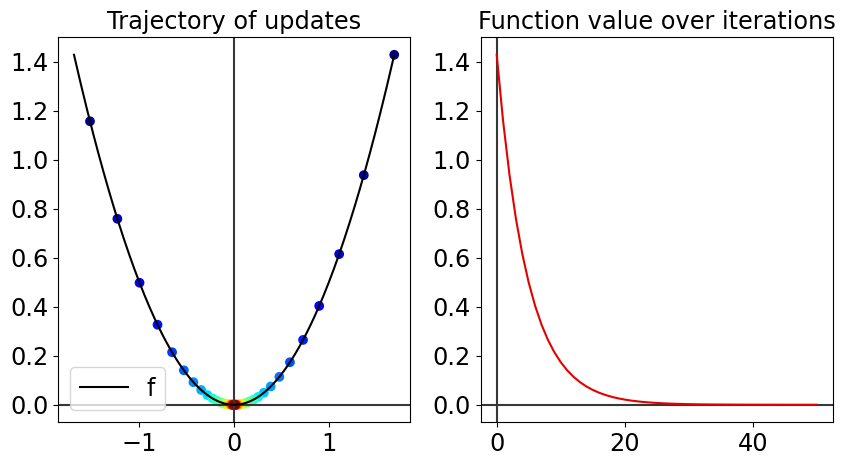

In [7]:
# Visualize performance.
x_range = np.linspace(-np.abs(w_init[0,0]), np.abs(w_init[0,0]), 250)
x_vals = algo.wstore[0,:]
y_vals = f(x_vals)
y_f = f(x_range)
t_steps = np.arange(0,t_max+1, 1)

myfig = plt.figure(figsize=(10,5))

ax1 = myfig.add_subplot(1,2,1)
plt.title("Trajectory of updates", fontsize=fontsize)
plt.axvline(x=0.0, color="xkcd:dark grey")
plt.axhline(y=0.0, color="xkcd:dark grey")
ax1.plot(x_range, y_f, color="xkcd:black", label="f")
ax1.tick_params(labelsize=fontsize)
c = np.linspace(0, 10, x_vals.size)
#ax1.plot(x_vals, y_vals, color="xkcd:red") # to connect points.
ax1.legend(loc="best", ncol=1, fontsize=fontsize)
ax1.scatter(x_vals, y_vals, c=c, cmap=cmap)

ax2 = myfig.add_subplot(1,2,2)
plt.title("Function value over iterations", fontsize=fontsize)
plt.axvline(x=0.0, color="xkcd:dark grey")
plt.axhline(y=0.0, color="xkcd:dark grey")
ax2.plot(t_steps, y_vals, color="xkcd:red")
ax2.tick_params(labelsize=fontsize)

plt.show()

上図（左）では、目的関数のグラフに乗せている点は各更新ステップにおける候補（横軸）とその候補が被る目的関数値（縦軸）の関係を表している。アルゴリズムの進行は色で表しており、青いほど起点に近く、赤いほど終点に近い。一方の上図（右）は補足情報として、目的関数値が時間とともにどう変化していくかを表している（横軸はステップ番号）。

### 演習

__(4.1) 勾配法の設定と挙動__

上述の例では勾配法が良い感じに最小解に収束していくことが確認できるが、いかなる設定でもこうなるとは限らない。勾配法のステップサイズ（`stepfix`で指定）に着目し、結果として発散するような設定を探ってみよう。講義資料を踏まえて「大きすぎるスッテプサイズ」の境界はどのあたりなのか、検討してみよう。

## 別の凸関数

先ほどの二次関数の例とは似ているが、今度は凸性を残しつつ、別の目的関数を対象に勾配法を応用してみる。

In [8]:
# Setup
t_max = 50
stepfix = 0.1
f = Poly15(shift=0.0, scale=2/3)

In [9]:
# Initiate algorithm.
step = lambda t, model, data, newdir : stepfix
w_init = np.array([1.69], dtype=np.float32).reshape((1,1))
algo = GD_Optim(w_init=w_init, step=step, t_max=t_max, store=True)

In [10]:
# Run algorithm.
for onestep in algo:
    algo.update(model=f, data=None)

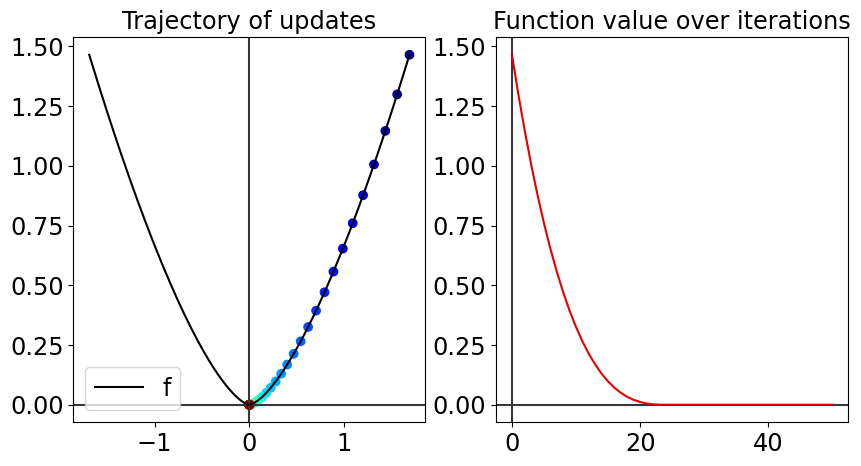

In [11]:
# Visualize performance.
x_range = np.linspace(-np.abs(w_init[0,0]), np.abs(w_init[0,0]), 250)
x_vals = algo.wstore[0,:]
y_vals = f(x_vals)
y_f = f(x_range)
t_steps = np.arange(0,t_max+1, 1)

myfig = plt.figure(figsize=(10,5))

ax1 = myfig.add_subplot(1,2,1)
plt.title("Trajectory of updates", fontsize=fontsize)
plt.axvline(x=0.0, color="xkcd:dark grey")
plt.axhline(y=0.0, color="xkcd:dark grey")
ax1.plot(x_range, y_f, color="xkcd:black", label="f")
ax1.tick_params(labelsize=fontsize)
c = np.linspace(0, 10, x_vals.size)
#ax1.plot(x_vals, y_vals, color="xkcd:red") # to connect points.
ax1.legend(loc="best", ncol=1, fontsize=fontsize)
ax1.scatter(x_vals, y_vals, c=c, cmap=cmap)

ax2 = myfig.add_subplot(1,2,2)
plt.title("Function value over iterations", fontsize=fontsize)
plt.axvline(x=0.0, color="xkcd:dark grey")
plt.axhline(y=0.0, color="xkcd:dark grey")
ax2.plot(t_steps, y_vals, color="xkcd:red")
ax2.tick_params(labelsize=fontsize)

plt.show()

上図では見えないかもしれないが、既定値ではこのアルゴリズムが振動している。格納している各ステップの候補を以下のように覗き込んでみよう。

In [12]:
print(algo.wstore)

[[ 1.6900001e+00  1.5600001e+00  1.4351001e+00  1.3153044e+00
   1.2006177e+00  1.0910450e+00  9.8659194e-01  8.8726461e-01
   7.9306990e-01  7.0401543e-01  6.2010980e-01  5.4136276e-01
   4.6778542e-01  3.9939058e-01  3.3619320e-01  2.7821103e-01
   2.2546531e-01  1.7798212e-01  1.3579419e-01  9.8943919e-02
   6.7488566e-02  4.1510001e-02  2.1135995e-02  6.5977694e-03
  -1.5248973e-03  2.3800961e-03 -2.4985273e-03  2.4999997e-03
  -2.5000002e-03  2.5000002e-03 -2.5000002e-03  2.5000002e-03
  -2.5000002e-03  2.5000002e-03 -2.5000002e-03  2.5000002e-03
  -2.5000002e-03  2.5000002e-03 -2.5000002e-03  2.5000002e-03
  -2.5000002e-03  2.5000002e-03 -2.5000002e-03  2.5000002e-03
  -2.5000002e-03  2.5000002e-03 -2.5000002e-03  2.5000002e-03
  -2.5000002e-03  2.5000002e-03 -2.5000002e-03]]


なるほど... 最終的には`2.50e-03`と`-2.50e-03`を延々と行き来するようになってしまっている。もう少し拡大して可視化するとなおわかりやすい。

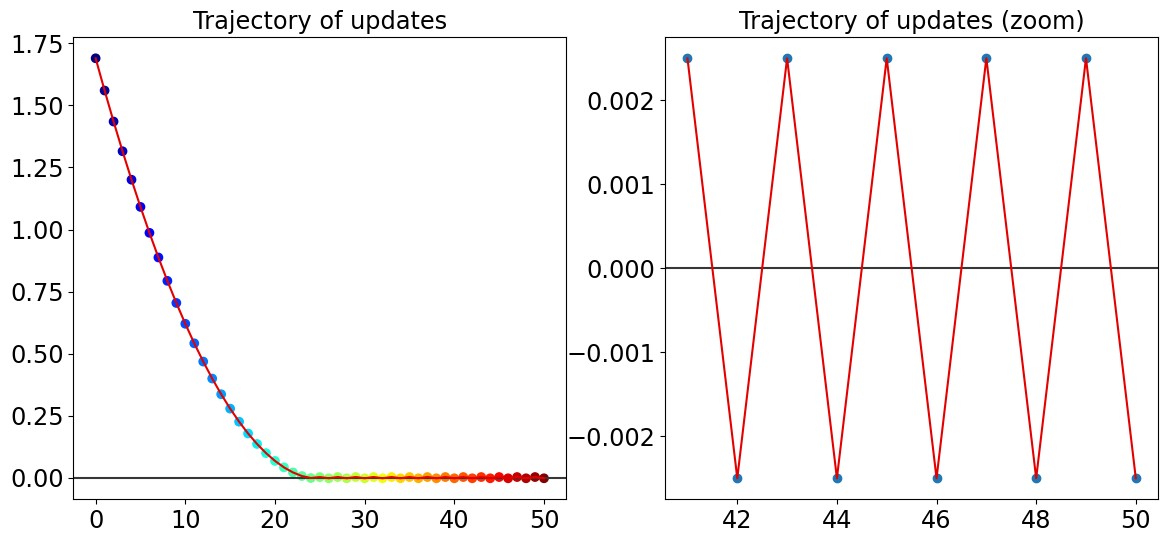

In [13]:
myfig = plt.figure(figsize=(14,6))

ax1 = myfig.add_subplot(1,2,1)
plt.title("Trajectory of updates", fontsize=fontsize)
plt.axhline(y=0.0, color="xkcd:dark grey")
ax1.tick_params(labelsize=fontsize)
c = np.linspace(0, 10, x_vals.size)
ax1.plot(t_steps, x_vals, color="xkcd:red") # to connect points.
ax1.scatter(t_steps, x_vals, c=c, cmap=cmap)

if t_steps.size > 10:
    zoom_idx = 10
else:
    zoom_idx = t_steps.size

ax2 = myfig.add_subplot(1,2,2)
plt.title("Trajectory of updates (zoom)", fontsize=fontsize)
plt.axhline(y=0.0, color="xkcd:dark grey")
ax2.tick_params(labelsize=fontsize)
c = np.linspace(0, 10, zoom_idx)
ax2.plot(t_steps[-zoom_idx:], x_vals[-zoom_idx:], color="xkcd:red") # to connect points.
ax2.scatter(t_steps[-zoom_idx:], x_vals[-zoom_idx:])

plt.show()

### 演習

__(4.2) 目的関数の性質と収束条件__

上述の例では、凸性と微分可能性という性質に恵まれながらも、勾配法が解になかなかたどり着かない。ステップサイズをより小さくし、十分な反復回数を経ていけば収束してくれるのか？ それとも、固定されたステップサイズの限界なのか？ 講義資料の中身を振り返り、自分なりの理解を文章としてまとめよう。

ヒント：目的関数「`Poly15`」の中身（最初に読み飛ばした`class`の宣言）を確認しよう。講義資料に登場する関数でもある。